## Query AAS abstract database
Based on this [blog post](http://adrn.github.io/posts/2016/01/aas-session-scheduling1/).

In [1]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import graphscheduler

% matplotlib inline

In [2]:
from datetime import datetime

In [3]:
conn = sqlite3.connect('aas_abstracts.sqlite')

In [4]:
engine = conn.cursor()
engine.execute("""SELECT DISTINCT(session.type) FROM session 
WHERE session.meeting_code = 'aas227';""")

In [5]:
engine.fetchall()

[(u'Special Session',),
 (u'Workshop',),
 (u'Splinter Meeting',),
 (u'Private Splinter Meeting',),
 (u'Attendee Event',),
 (u'Invitation-Only Event',),
 (u'Town Hall',),
 (u'Plenary Session',),
 (u'Poster Session',),
 (u'Oral Session',),
 (u'Open Event',),
 (u'Public Event',)]

In [6]:
query = """
SELECT session.title, session.start_date_time, session.end_date_time, session.so_id
FROM session
WHERE session.meeting_code = 'aas227'
    AND session.type IN (
        'Oral Session',
        'Special Session',
        'Splinter Meeting'
    )
ORDER BY session.so_id;
"""
session_results = engine.execute(query).fetchall()

In [7]:
session_results[0]

(u'Astrophysical Constraints of Dark Matter Properties (DUPLICATE)',
 u'1969-12-31 19:00:00',
 u'1969-12-31 19:00:00',
 212362)

In [8]:
# load the presentation data into a Pandas DataFrame
sess_cols = ['title', 'start_date_time', 'end_date_time', 'so_id']
session_df = pd.DataFrame(session_results) #, session_results[0].keys())
session_df.columns = sess_cols

In [9]:
# turn the timestamps into datetime
session_df['start_date_time'] = pd.to_datetime(session_df['start_date_time']) 
session_df['end_date_time'] = pd.to_datetime(session_df['end_date_time'])
session_df = session_df[1:] # zero-th entry has a corrupt date
session_df.head()

,title,start_date_time,end_date_time,so_id
1,Lectures in AstroStatistics,2016-01-06 10:00:00,2016-01-06 11:30:00,212363
2,Hubble Space Telescope: a Vision to 2020 and B...,2016-01-06 14:00:00,2016-01-06 15:30:00,212364
3,The Astrophysics of Exoplanet Orbital Phase Cu...,2016-01-06 14:00:00,2016-01-06 15:30:00,212365
4,The Cosmic History of Light: New Results and F...,2016-01-08 10:00:00,2016-01-08 11:30:00,212366
5,A Report from the Inclusive Astronomy 2015 Mee...,2016-01-06 14:00:00,2016-01-06 15:30:00,212367


In [10]:
query = """
SELECT presentation.title, presentation.abstract, presentation.id, session.so_id
FROM session, presentation
WHERE session.meeting_code = 'aas227'
    AND session.so_id = presentation.session_so_id
    AND presentation.status IN ('Sessioned', '')
    AND session.type IN (
        'Oral Session', 
        'Special Session',
        'Splinter Meeting'
    )
ORDER BY presentation.id;
"""
presentation_results = engine.execute(query).fetchall()

In [11]:
# sort the presentatons by session
presentation_results = sorted(presentation_results, key=lambda x: x[-1])# ['so_id'])
pres_cols = ['title', 'abstract', 'id', 'so_id']
# load the presentation data into a Pandas DataFrame and clean out HTML tags
presentation_df = pd.DataFrame(presentation_results) #, columns=presentation_results[0].keys())
presentation_df.columns = pres_cols
presentation_df['abstract'] = presentation_df['abstract'].str.replace('<[^<]+?>', '')
presentation_df['title'] = presentation_df['title'].str.replace('<[^<]+?>', '')

In [12]:
presentation_df.head()

,title,abstract,id,so_id
0,A Plan for Astrophysical Constraints of Dark M...,We present conclusions and challenges for a co...,21704,212362
1,The Likelihood Function and Likelihood Statistics,The likelihood function is a necessary compone...,21706,212363
2,From least squares to multilevel modeling: A g...,This tutorial presentation will introduce some...,21707,212363
3,Topics in Machine Learning for Astronomers,As astronomical datasets continue to increase ...,21708,212363
4,Maximizing the Scientific Return and Legacy of...,The Hubble Space Telescope has pushed the fore...,21709,212364


In [13]:
nsessions = len(session_df)
npresentations = len(presentation_df)
print(nsessions, npresentations)

(139, 675)


In [14]:
import nltk
from nltk.stem.porter import PorterStemmer
import re

In [15]:
def tokenize(text, stemmer=PorterStemmer()):
    # remove non letters
    text = re.sub("[^a-zA-Z]", " ", text)
    
    # tokenize
    tokens = nltk.word_tokenize(text)
    
    # stem
    stems = [stemmer.stem(token) for token in tokens]
    
    return stems

In [16]:
tokenize("This image contains one foreground galaxy and many background galaxies")

[u'Thi',
 u'imag',
 u'contain',
 u'one',
 u'foreground',
 u'galaxi',
 u'and',
 u'mani',
 u'background',
 u'galaxi']

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
    analyzer='word',
    tokenizer=tokenize,
    lowercase=True,
    stop_words='english',
)

In [18]:
example_titles = ["Exoplanets, exoplanets, exoplanets", "I found an exoplanet", 
                  "Stuff that explodes in space"]
example_count_matrix = vectorizer.fit_transform(example_titles).toarray()
vectorizer.get_feature_names()

[u'exoplanet', u'explod', u'space', u'stuff']

In [19]:
example_count_matrix[0]

array([3, 0, 0, 0])

In [20]:
title_count_matrix = vectorizer.fit_transform(presentation_df['title']).toarray()
title_count_matrix.shape

(675, 1503)

In [21]:
title_counts = title_count_matrix.sum(axis=0)
sort_by_count_idx = title_counts.argsort()[::-1] # reverse sort
words = np.array(vectorizer.get_feature_names())

# print the word stem and the number of occurrences
for idx in sort_by_count_idx[:10]:
    print(words[idx], title_counts[idx])

(u'galaxi', 101)
(u'star', 82)
(u'survey', 66)
(u'ray', 58)
(u'mass', 50)
(u'format', 45)
(u'observ', 44)
(u'stellar', 36)
(u'cluster', 34)
(u'disk', 33)


In [22]:
abs_count_matrix = vectorizer.fit_transform(presentation_df['abstract']).toarray()
abs_count_matrix.shape

(675, 5567)

In [23]:
abs_counts = abs_count_matrix.sum(axis=0)
sort_by_count_idx = abs_counts.argsort()[::-1] # reverse sort
words = np.array(vectorizer.get_feature_names())

# print the word stem and the number of occurrences
for idx in sort_by_count_idx[:10]:
    print(words[idx], abs_counts[idx])

(u'galaxi', 1042)
(u'star', 948)
(u'thi', 850)
(u'observ', 798)
(u'mass', 686)
(u'use', 672)
(u'model', 441)
(u'survey', 437)
(u'format', 422)
(u'present', 387)


In [24]:
def similarity(v1, v2):
    numer = v1.dot(v2)
    denom = np.linalg.norm(v1) * np.linalg.norm(v2)

    if numer < 1: # if no common words, the vectors are orthogonal
        return 0.
    else:
        return numer / denom

In [25]:
example_count_matrix

array([[3, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 1, 1]])

In [26]:
sim_01 = similarity(example_count_matrix[0], example_count_matrix[1])
sim_02 = similarity(example_count_matrix[0], example_count_matrix[2])
sim_12 = similarity(example_count_matrix[1], example_count_matrix[2])

sim_01, sim_02, sim_12

(1.0, 0.0, 0.0)

In [27]:
similarity_matrix = np.zeros((npresentations, npresentations))
for ix1 in range(npresentations):
    for ix2 in range(npresentations):
        similarity_matrix[ix1,ix2] = similarity(abs_count_matrix[ix1], abs_count_matrix[ix2])

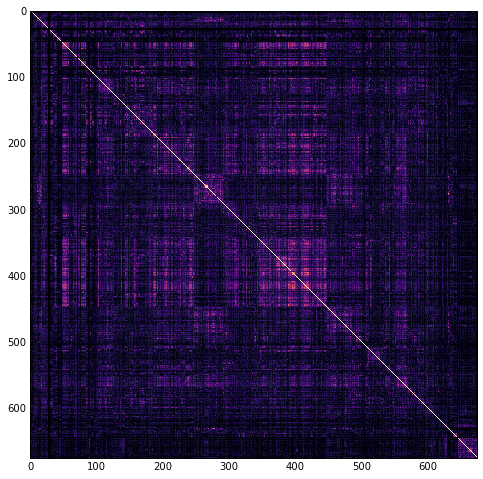

In [28]:
plt.figure(figsize=(8,8))
vmax = similarity_matrix[similarity_matrix < 0.99].max()
plt.imshow(similarity_matrix, cmap='magma', interpolation='nearest',
          vmax=vmax)

In [29]:
triu_similarity_matrix = np.triu(similarity_matrix)
similarity_matrix_1d = triu_similarity_matrix.ravel()
sorted_sim = np.sort(similarity_matrix_1d[~np.isclose(similarity_matrix_1d, 1.)])[::-1]

most_similar_idx = np.where((triu_similarity_matrix >= sorted_sim[9]) & 
                            (~np.isclose(similarity_matrix, 1.)))
most_similar_idx = np.vstack(most_similar_idx).T

In [30]:
for ix1,ix2 in most_similar_idx:
    pres1 = presentation_df.iloc[ix1]
    pres2 = presentation_df.iloc[ix2]
    print(pres1['title'])
    print(pres2['title'])
    print()

Constraining the atmosphere of exoplanet WASP-34b
Analysis of Secondary Eclipse Observations of Hot-Jupiters WASP-26b and CoRoT-1b
()
Constraining the atmosphere of exoplanet WASP-34b
Atmospheric, Orbital and Secondary Eclipse Analysis of HAT-P-30-WASP-51b
()
Constraining the atmosphere of exoplanet WASP-34b
Secondary Eclipse Observations and Orbital Analysis of WASP-32b
()
Analysis of Secondary Eclipse Observations of Hot-Jupiters WASP-26b and CoRoT-1b
Atmospheric, Orbital and Secondary Eclipse Analysis of HAT-P-30-WASP-51b
()
Analysis of Secondary Eclipse Observations of Hot-Jupiters WASP-26b and CoRoT-1b
Secondary Eclipse Observations and Orbital Analysis of WASP-32b
()
Atmospheric, Orbital and Secondary Eclipse Analysis of HAT-P-30-WASP-51b
Secondary Eclipse Observations and Orbital Analysis of WASP-32b
()
How Giant Planets Shape the Characteristics of Terrestrial Planets
The Fragility of the Terrestrial Planets During a Giant Planet Instability
()
Galaxy Structure as a Driver of t

In [31]:
from sklearn.utils.extmath import cartesian

def session_similarity(so_id1, so_id2):
    """
    Getting the sub-matrix of the similarity matrix for all pairs 
    of presentations between two session ID's.
    """
    presentations_session1 = presentation_df[presentation_df['so_id'] == so_id1]
    presentations_session2 = presentation_df[presentation_df['so_id'] == so_id2]
    
    if len(presentations_session1) == 0 or len(presentations_session2) == 0:
        # no presentations in session
        return np.array([])
    
    index_pairs = cartesian((presentations_session1.index,presentations_session2.index)).T
    sub_matrix = similarity_matrix[(index_pairs[0],index_pairs[1])]
    
    shape = (len(presentations_session1), len(presentations_session2))
    sub_matrix = sub_matrix.reshape(shape)
    
    return sub_matrix

In [32]:
session_df = session_df[:-1]
session_df.head()

,title,start_date_time,end_date_time,so_id
1,Lectures in AstroStatistics,2016-01-06 10:00:00,2016-01-06 11:30:00,212363
2,Hubble Space Telescope: a Vision to 2020 and B...,2016-01-06 14:00:00,2016-01-06 15:30:00,212364
3,The Astrophysics of Exoplanet Orbital Phase Cu...,2016-01-06 14:00:00,2016-01-06 15:30:00,212365
4,The Cosmic History of Light: New Results and F...,2016-01-08 10:00:00,2016-01-08 11:30:00,212366
5,A Report from the Inclusive Astronomy 2015 Mee...,2016-01-06 14:00:00,2016-01-06 15:30:00,212367


In [ ]:
len(session_df)

In [33]:
#grouped_sessions = session_df[session_df['start_date_time'] >= 
# datetime(2016, 1, 5)].groupby('start_date_time')
empty_session = 0

#for start_time,group in grouped_sessions:
titles = []
max_scores = []
for title1,so_id1 in zip(session_df['title'],session_df['so_id']):
    for title2,so_id2 in zip(session_df['title'],session_df['so_id']):
        if so_id1 >= so_id2: continue # only fill the upper triangle

        # similarity between all pairs of presentations between the two sessions
        scores = session_similarity(so_id1, so_id2)

        if scores.size == 0: # no presentations in one of the sessions
            empty_session += 1
            continue

        max_scores.append(scores.max())
        titles.append([title1, title2])

#if len(max_scores) < 1:
#    continue

#print(start_time) # the start_time
max_idx = np.argmax(max_scores)
for t in titles[max_idx]:
    print(t)
print(max_scores[max_idx])
print()

Extrasolar Planets: Hosts, Interactions, Formation, and Interiors
Astrobiology/Laboratory Astrophysics - Atoms and Plasmas
0.681945681113
()


In [34]:
print(len(max_scores))

5253


In [35]:
empty_session

4200

In [36]:
session_df.count()

title              138
start_date_time    138
end_date_time      138
so_id              138
dtype: int64

In [37]:
139*138/2.

9591.0

In [38]:
import networkx as nx

In [54]:
G = nx.Graph()
empty_session = 0

#for start_time,group in grouped_sessions:
titles = []
max_scores = []
for title1,so_id1 in zip(session_df['title'],session_df['so_id']):
    for title2,so_id2 in zip(session_df['title'],session_df['so_id']):
        if so_id1 >= so_id2: continue # only fill the upper triangle

        # similarity between all pairs of presentations between the two sessions
        scores = session_similarity(so_id1, so_id2)

        if scores.size == 0: # no presentations in one of the sessions
            empty_session += 1
            continue

        #max_scores.append(scores.max())
        #titles.append([title1, title2])
        G.add_node(title1)
        G.add_node(title2)
        G.add_edge(title1, title2, weight=1.-scores.max())
        

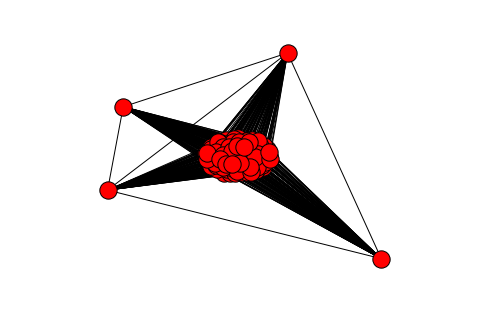

In [55]:
nx.draw(G)

In [56]:
G.number_of_nodes()

103

In [57]:
session_df.count()

title              138
start_date_time    138
end_date_time      138
so_id              138
dtype: int64

In [ ]:
n_elements = 3
results = graphscheduler.find_solution_numerical(G, n_elements)

In [ ]:
G.number_of_nodes() % n_elements